## Imports and installations

In [0]:
! rm -r biology_test_solving
! git clone -q https://github.com/katchinsky/biology_test_solving

In [0]:
! pip install -q -U -r biology_test_solving/requirements.txt

In [0]:
from biology_test_solving.source.utils import get_unique_tasks, evaluate_model_on_different_tasks, cross_validation
from biology_test_solving.source.constants import QUESTION_TYPES, RAW_DATA_FOLDER
from biology_test_solving.source.parser import Parser
from biology_test_solving.source.utils import Dummy, TSNEWithTransform, cross_validation
from biology_test_solving.source.constants import DP_RU_BERT_MODEL_PATH, RU_BERT_MODEL, RU_WIKI_PATH
from biology_test_solving.source.solvers import (RandomSolver, 
                                    SimpleBertSolver, 
                                    SimpleDPBertSolver, 
                                    AnotherBERTClassificationSolver, 
                                    ClassificationSolver, 
                                    BaseSolver,
                                    ContextBertSolver,
                                    OptionsContextBertSolver, 
                                    QuadraticFormSolver, 
                                    QuadraticFormWithProjectionsSolver,
                                    QuadraticForm
                                    )

from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.manifold import TSNE
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics.pairwise import cosine_similarity

from deeppavlov import configs, build_model
from deeppavlov.core.common.file import read_json
from deeppavlov.vocabs.wiki_sqlite import WikiSQLiteVocab

from sentence_transformers import SentenceTransformer

from torch import nn
import torch

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from copy import deepcopy
from IPython.display import clear_output

bert_config = configs.embedder.bert_embedder

## Downloading Data

In [0]:
parser = Parser(RAW_DATA_FOLDER)
tasks = parser()
tasks = get_unique_tasks(tasks)

In [0]:
parser.all_tasks_cnt, parser.without_answer_cnt, parser.with_image_cnt, parser.with_table_cnt

(5040, 1570, 511, 854)

In [0]:
5040 - 1570 - 511 - 854

2105

## Some little data analysis

In [0]:
pd.set_option('max_colwidth', 1000)

data = deepcopy(tasks)
for i, elem in enumerate(tasks):
    data[i].update(elem['options'])
df = pd.DataFrame(data)
df.drop('options', axis=1, inplace=True)
df.head(5)

,question,type,answers,number_options,letter_options
0,установите соответствие между примерами и типом отношений организмов в экосистеме,2,[122111],"[симбиоз, комменсализм]","[распространение пыльцы некоторых растений одним видом насекомых, акула и рыба-прилипало, орхидеи, поселяющиеся на деревьях, бактерии в организме человека и животных, клубеньковые бактерии, микориза]"
1,"установите, в какой последовательности происходят процессы митоза.",4,[2314],"[расхождение сестринских хроматид., спирализация хромосом., образование метафазной пластинки., деление цитоплазмы.]",[]
2,"сколько молекул днк содержится в ядре клетки после репликации, если в диплоидном наборе содержится 46 молекул днк? в ответе запишите только соответствующее число.",5,[92],[],[]
3,в тонком кишечнике происходит всасывание в кровь:,1,[126],"[глюкозы, аминокислот, жирных кислот, гликогена, клетчатки, фруктоза]",[]
4,"все приведённые ниже признаки, кроме двух, можно использовать для описания процесса биосинтеза белка в клетке. определите два признака, «выпадающих» из общего списка, и запишите в ответ цифры, под которыми они указаны.",1,[35],"[процесс происходит при наличии ферментов., центральная роль в процессе принадлежит молекулам рнк., процесс сопровождается синтезом атф., мономерами для образования молекул служат аминокислоты., сборка молекул белков осуществляется в лизосомах.]",[]


In [0]:
types = parser.types

df['type_descr'] = df['type'].map(types)
df[['type_descr', 'question']].groupby('type_descr').count()

,question
type_descr,
match_terms,284
multiple_choice,292
number,52
order,109
percents,22
question,51


In [0]:
types

{0: 'question',
 1: 'multiple_choice',
 2: 'match_terms',
 3: 'percents',
 4: 'order',
 5: 'number'}

In [0]:
df[df['type'] == 1].head(20)

# Solvers

In [0]:
tasks = list(filter(lambda x: x['type'] in (1, 2), tasks))

## Random Solver


- multiple choice: 0.4831
- match terms: 0.4667
---------

In [0]:
from collections import defaultdict

solver = RandomSolver()
mean_metrics = defaultdict(int)
for i in range(200):
    answers = solver(tasks)
    metrics = evaluate_model_on_different_tasks(answers, tasks, need_print=False)
    for metric in metrics:
        mean_metrics[metric] += metrics[metric] / 200
    clear_output()
print('multiple choice:', mean_metrics[('non_position_accuracy', 'multiple_choice')])
print('match terms:', mean_metrics[('position_accuracy', 'match_terms')])

multiple choice: 0.4830990220048902
match terms: 0.46665632754342445


## Simple Sentence transformer BERT model
- multiple choice: 0.5098
- match terms: 0.4750

In [0]:
solver = SimpleBertSolver(RU_BERT_MODEL)

In [0]:
answers = solver(tasks)

need at least one array to concatenate {'question': 'для каждой особенности деления животной клетки установите, характерна она для митоза (', 'options': {'number_options': ['или мейоза (', ': особенности   тип деления а) в результате образуются 2 клеткиб) в результате образуются 4 клеткив) дочерние клетки гаплоидныг) дочерние клетки диплоидныд) происходят конъюгация и перекрест хромосоме) не происходит кроссинговер', 'митоз', 'мейоз'], 'letter_options': []}, 'type': 2, 'answers': ['122121']}



In [0]:
metrics = evaluate_model_on_different_tasks(answers, tasks, need_print=False)
print('multiple choice:', metrics[('non_position_accuracy', 'multiple_choice')])
print('match terms:', metrics[('position_accuracy', 'match_terms')])

multiple choice: 0.5097799511002445
match terms: 0.475093399750934


## Simple DeepPavlov BERT model
good russian embeddings


sent_mean_embs:
- multiple choice: 0.4987
- match terms: 0.475


sent_max_embs:
- multiple choice: 0.4878
- match terms: 0.485

In [0]:
! rm rubert_cased_L-12_H-768_A-12_pt.tar.gz
! wget http://files.deeppavlov.ai/deeppavlov_data/bert/rubert_cased_L-12_H-768_A-12_pt.tar.gz
! tar -zxvf rubert_cased_L-12_H-768_A-12_pt.tar.gz

rubert_cased_L-12_H 100%[===================>] 631.36M   934KB/s    in 8m 19s  

2020-05-20 12:59:43 (1.26 MB/s) - ‘rubert_cased_L-12_H-768_A-12_pt.tar.gz’ saved [662024852/662024852]

rubert_cased_L-12_H-768_A-12_pt/
rubert_cased_L-12_H-768_A-12_pt/bert_config.json
rubert_cased_L-12_H-768_A-12_pt/vocab.txt
rubert_cased_L-12_H-768_A-12_pt/pytorch_model.bin


In [0]:
solver = SimpleDPBertSolver(bert_config, emb_type='sent_mean_embs')
answers = solver(tasks)
metrics = evaluate_model_on_different_tasks(answers, tasks, need_print=False)

list index out of range {'question': 'для каждой особенности деления животной клетки установите, характерна она для митоза (', 'options': {'number_options': ['или мейоза (', ': особенности   тип деления а) в результате образуются 2 клеткиб) в результате образуются 4 клеткив) дочерние клетки гаплоидныг) дочерние клетки диплоидныд) происходят конъюгация и перекрест хромосоме) не происходит кроссинговер', 'митоз', 'мейоз'], 'letter_options': []}, 'type': 2, 'answers': ['122121']}



In [0]:
print('multiple choice:', metrics[('non_position_accuracy', 'multiple_choice')])
print('match terms:', metrics[('position_accuracy', 'match_terms')])

multiple choice: 0.49877750611246946
match terms: 0.475093399750934


In [0]:
solver = SimpleDPBertSolver(bert_config, emb_type='sent_max_embs')
answers = solver(tasks)
metrics = evaluate_model_on_different_tasks(answers, tasks, need_print=False)

In [0]:
print('multiple choice:', metrics[('non_position_accuracy', 'multiple_choice')])
print('match terms:', metrics[('position_accuracy', 'match_terms')])

multiple choice: 0.4877750611246944
match terms: 0.48567870485678705


In [0]:
options = {'question_kwargs': {'emb_type': 'sent_max_embs'}, 
           'options_kwargs': {'emb_type': 'sent_mean_embs'}}
solver = SimpleDPBertSolver(bert_config, options=options)
answers = solver(tasks)
metrics = evaluate_model_on_different_tasks(answers, tasks, need_print=False)

list index out of range {'question': 'для каждой особенности деления животной клетки установите, характерна она для митоза (', 'options': {'number_options': ['или мейоза (', ': особенности   тип деления а) в результате образуются 2 клеткиб) в результате образуются 4 клеткив) дочерние клетки гаплоидныг) дочерние клетки диплоидныд) происходят конъюгация и перекрест хромосоме) не происходит кроссинговер', 'митоз', 'мейоз'], 'letter_options': []}, 'type': 2, 'answers': ['122121']}



In [0]:
print('multiple choice:', metrics[('non_position_accuracy', 'multiple_choice')])
print('match terms:', metrics[('position_accuracy', 'match_terms')])

multiple choice: 0.4767726161369193
match terms: 0.4676214196762142


In [0]:
options = {'question_kwargs': {'emb_type': 'sent_mean_embs'}, 
           'options_kwargs': {'emb_type': 'sent_max_embs'}}
solver = SimpleDPBertSolver(bert_config, options=options)
answers = solver(tasks)
metrics = evaluate_model_on_different_tasks(answers, tasks, need_print=False)

In [0]:
print('multiple choice:', metrics[('non_position_accuracy', 'multiple_choice')])
print('match terms:', metrics[('position_accuracy', 'match_terms')])

## BERT model with dimensionality reduction and classifier

In [0]:
bert_config = read_json(bert_config)
bert_config['metadata']['variables']['BERT_PATH'] = DP_RU_BERT_MODEL_PATH

### DP Bert + PCA (128) + LogReg
- multiple choice: 0.4789
- match terms: 0.4689

In [0]:
args = [{
            'model': build_model,
            'args': [bert_config],
        },
        {
            'model': PCA,
            'args': [128]
        },
        {
            'model': LogisticRegression,
            'kwargs': {'solver': 'lbfgs',
                       'penalty': 'l2'}
        },
        ]

kwargs = dict(emb_type='sent_max_embs')

metrics = cross_validation(ClassificationSolver, args, kwargs, tasks, n_iter=3)

In [0]:
print('multiple choice:', metrics[('non_position_accuracy', 'multiple_choice')])
print('match terms:', metrics[('position_accuracy', 'match_terms')])

multiple choice: 0.47888713868357635
match terms: 0.468908290144167


### DP Bert + LogReg
- multiple choice: 0.5016353059065858
- match terms: 0.47139971930305

In [0]:
args = [{
            'model': build_model,
            'args': [bert_config],
        },
        {
            'model': Dummy,
        },
        {
            'model': LogisticRegression,
            'kwargs': {'solver': 'lbfgs',
                       'penalty': 'l2'}
        },
        ]

kwargs = dict(emb_type='sent_max_embs')

metrics = cross_validation(ClassificationSolver, args, kwargs, tasks, n_iter=2)

In [0]:
print('multiple choice:', metrics[('non_position_accuracy', 'multiple_choice')])
print('match terms:', metrics[('position_accuracy', 'match_terms')])

### Sentence Transformer Bert + PCA (128) + RandomForest (10)
- multiple choice: 0.5222
- match terms: 0.4662

In [0]:
args = [{
            'model': SentenceTransformer,
            'args': [RU_BERT_MODEL]
        },
        {
            'model': PCA,
            'args': [128]
        },
        {
            'model': RandomForestClassifier,
            'kwargs': {'n_estimators': 10, 'max_depth': 3}
        },
        ]

metrics = cross_validation(AnotherBERTClassificationSolver, args, {}, tasks, n_iter=3)

processing and encoding tasks...  

string index out of range {'question': 'установите соответствие между признаком, характеризующим неясыть (семейство совины', 'options': {'number_options': ['физиологический', 'экологический'], 'letter_options': ['и критерием вида признак   критерий вида', 'голос самки — раскатистая басовая трель', 'питается мышевидными грызунами', 'гнездится в смешанных лесах', 'охотится ночью', 'в кладке 2-6 белых яиц', 'птенцы насиживаются самкой 30 суток']}, 'type': 2, 'answers': ['122211']}

fitting reduction method....  reducing dimensions.....  fitting classifier......   evaluating.........


string index out of range {'question': 'установите соответствие между функцией отдела нервной системы и отделом', 'options': {'number_options': ['соматическая нервная система', 'вегетативная нервная система'], 'letter_options': ['иннервирует скелетную мускулатуру', 'подконтрольна сознанию', 'автономна', 'центры расположены в промежуточном, продолговатом и спинном мозге', 'вне центральной нервной системы вторых узлов (ганглие', 'нет']}, 'type': 2, 'answers': ['11221']}

processing and encoding tasks...  

string index out of range {'question': 'установите соответствие между функцией отдела нервной системы и отделом', 'options': {'number_options': ['соматическая нервная система', 'вегетативная нервная система'], 'letter_options': ['иннервирует скелетную мускулатуру', 'подконтрольна сознанию', 'автономна', 'центры расположены в промежуточном, продолговатом и спинном мозге', 'вне центральной нервной системы вторых узлов (ганглие', 'нет']}, 'type': 2, 'answers': ['11221']}

fitting reduction method....  reducing dimensions.....  fitting classifier......   evaluating.........


string index out of range {'question': 'установите соответствие между признаком, характеризующим неясыть (семейство совины', 'options': {'number_options': ['физиологический', 'экологический'], 'letter_options': ['и критерием вида признак   критерий вида', 'голос самки — раскатистая басовая трель', 'питается мышевидными грызунами', 'гнездится в смешанных лесах', 'охотится ночью', 'в кладке 2-6 белых яиц', 'птенцы насиживаются самкой 30 суток']}, 'type': 2, 'answers': ['122211']}
Expected 2D array, got 1D array instead:
array=[].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample. {'question': 'для каждой особенности деления животной клетки установите, характерна она для митоза (', 'options': {'number_options': ['или мейоза (', ': особенности   тип деления а) в результате образуются 2 клеткиб) в результате образуются 4 клеткив) дочерние клетки гаплоидныг) дочерние клетки диплоидныд) происходят конъю

string index out of range {'question': 'установите соответствие между признаком, характеризующим неясыть (семейство совины', 'options': {'number_options': ['физиологический', 'экологический'], 'letter_options': ['и критерием вида признак   критерий вида', 'голос самки — раскатистая басовая трель', 'питается мышевидными грызунами', 'гнездится в смешанных лесах', 'охотится ночью', 'в кладке 2-6 белых яиц', 'птенцы насиживаются самкой 30 суток']}, 'type': 2, 'answers': ['122211']}
string index out of range {'question': 'установите соответствие между функцией отдела нервной системы и отделом', 'options': {'number_options': ['соматическая нервная система', 'вегетативная нервная система'], 'letter_options': ['иннервирует скелетную мускулатуру', 'подконтрольна сознанию', 'автономна', 'центры расположены в промежуточном, продолговатом и спинном мозге', 'вне центральной нервной системы вторых узлов (ганглие', 'нет']}, 'type': 2, 'answers': ['11221']}

fitting reduction method....  reducing dime

In [0]:
print('multiple choice:', metrics[('non_position_accuracy', 'multiple_choice')])
print('match terms:', metrics[('position_accuracy', 'match_terms')])

multiple choice: 0.5222962259406485
match terms: 0.4661797145616102


### DP Bert + PCA (128) + RandomForest (100)
- multiple choice: 0.4771
- match terms: 0.4351

In [0]:
args = [{
            'model': build_model,
            'args': [bert_config]
        },
        {
            'model': PCA,
            'args': [128]
        },
        {
            'model': RandomForestClassifier,
            'kwargs': {'n_estimators': 100, 'max_depth': 3}
        },
        ]

metrics = cross_validation(ClassificationSolver, args, dict(emb_type='sent_max_embs'), tasks, n_iter=3)

processing and encoding tasks...  

string index out of range {'question': 'установите соответствие между признаком, характеризующим неясыть (семейство совины', 'options': {'number_options': ['физиологический', 'экологический'], 'letter_options': ['и критерием вида признак   критерий вида', 'голос самки — раскатистая басовая трель', 'питается мышевидными грызунами', 'гнездится в смешанных лесах', 'охотится ночью', 'в кладке 2-6 белых яиц', 'птенцы насиживаются самкой 30 суток']}, 'type': 2, 'answers': ['122211']}
string index out of range {'question': 'установите соответствие между функцией отдела нервной системы и отделом', 'options': {'number_options': ['соматическая нервная система', 'вегетативная нервная система'], 'letter_options': ['иннервирует скелетную мускулатуру', 'подконтрольна сознанию', 'автономна', 'центры расположены в промежуточном, продолговатом и спинном мозге', 'вне центральной нервной системы вторых узлов (ганглие', 'нет']}, 'type': 2, 'answers': ['11221']}

fitting reduction method....  reducing dime


processing and encoding tasks...  

string index out of range {'question': 'установите соответствие между признаком, характеризующим неясыть (семейство совины', 'options': {'number_options': ['физиологический', 'экологический'], 'letter_options': ['и критерием вида признак   критерий вида', 'голос самки — раскатистая басовая трель', 'питается мышевидными грызунами', 'гнездится в смешанных лесах', 'охотится ночью', 'в кладке 2-6 белых яиц', 'птенцы насиживаются самкой 30 суток']}, 'type': 2, 'answers': ['122211']}

fitting reduction method....  reducing dimensions.....  fitting classifier......   evaluating.........


string index out of range {'question': 'установите соответствие между функцией отдела нервной системы и отделом', 'options': {'number_options': ['соматическая нервная система', 'вегетативная нервная система'], 'letter_options': ['иннервирует скелетную мускулатуру', 'подконтрольна сознанию', 'автономна', 'центры расположены в промежуточном, продолговатом и спинном мозге', 'вне центральной нервной системы вторых узлов (ганглие', 'нет']}, 'type': 2, 'answers': ['11221']}

processing and encoding tasks...  


fitting reduction method....  reducing dimensions.....  fitting classifier......   evaluating.........


string index out of range {'question': 'установите соответствие между признаком, характеризующим неясыть (семейство совины', 'options': {'number_options': ['физиологический', 'экологический'], 'letter_options': ['и критерием вида признак   критерий вида', 'голос самки — раскатистая басовая трель', 'питается мышевидными грызунами', 'гнездится в смешанных лесах', 'охотится ночью', 'в кладке 2-6 белых яиц', 'птенцы насиживаются самкой 30 суток']}, 'type': 2, 'answers': ['122211']}
string index out of range {'question': 'установите соответствие между функцией отдела нервной системы и отделом', 'options': {'number_options': ['соматическая нервная система', 'вегетативная нервная система'], 'letter_options': ['иннервирует скелетную мускулатуру', 'подконтрольна сознанию', 'автономна', 'центры расположены в промежуточном, продолговатом и спинном мозге', 'вне центральной нервной системы вторых узлов (ганглие', 'нет']}, 'type': 2, 'answers': ['11221']}



In [0]:
print('multiple choice:', metrics[('non_position_accuracy', 'multiple_choice')])
print('match terms:', metrics[('position_accuracy', 'match_terms')])

multiple choice: 0.4770954657498002
match terms: 0.4351498927052173


### DP Bert + RandomForest (100)

- multiple choice: 0.4584
- match terms: 0.4730

In [0]:
args = [{
            'model': build_model,
            'args': [bert_config]
        },
        {
            'model': Dummy,
        },
        {
            'model': RandomForestClassifier,
            'kwargs': {'n_estimators': 100,  'max_depth': 3}
        },
        ]

metrics = cross_validation(ClassificationSolver, args, {}, tasks, n_iter=3)

processing and encoding tasks...  

string index out of range {'question': 'установите соответствие между функцией отдела нервной системы и отделом', 'options': {'number_options': ['соматическая нервная система', 'вегетативная нервная система'], 'letter_options': ['иннервирует скелетную мускулатуру', 'подконтрольна сознанию', 'автономна', 'центры расположены в промежуточном, продолговатом и спинном мозге', 'вне центральной нервной системы вторых узлов (ганглие', 'нет']}, 'type': 2, 'answers': ['11221']}
string index out of range {'question': 'установите соответствие между признаком, характеризующим неясыть (семейство совины', 'options': {'number_options': ['физиологический', 'экологический'], 'letter_options': ['и критерием вида признак   критерий вида', 'голос самки — раскатистая басовая трель', 'питается мышевидными грызунами', 'гнездится в смешанных лесах', 'охотится ночью', 'в кладке 2-6 белых яиц', 'птенцы насиживаются самкой 30 суток']}, 'type': 2, 'answers': ['122211']}

fitting reduction method....  reducing dime


processing and encoding tasks...  


fitting reduction method....  reducing dimensions.....  fitting classifier......   evaluating.........


string index out of range {'question': 'установите соответствие между функцией отдела нервной системы и отделом', 'options': {'number_options': ['соматическая нервная система', 'вегетативная нервная система'], 'letter_options': ['иннервирует скелетную мускулатуру', 'подконтрольна сознанию', 'автономна', 'центры расположены в промежуточном, продолговатом и спинном мозге', 'вне центральной нервной системы вторых узлов (ганглие', 'нет']}, 'type': 2, 'answers': ['11221']}
string index out of range {'question': 'установите соответствие между признаком, характеризующим неясыть (семейство совины', 'options': {'number_options': ['физиологический', 'экологический'], 'letter_options': ['и критерием вида признак   критерий вида', 'голос самки — раскатистая басовая трель', 'питается мышевидными грызунами', 'гнездится в смешанных лесах', 'охотится ночью', 'в кладке 2-6 белых яиц', 'птенцы насиживаются самкой 30 суток']}, 'type': 2, 'answers': ['122211']}

processing and encoding tasks...  

string index out of range {'question': 'установите соответствие между функцией отдела нервной системы и отделом', 'options': {'number_options': ['соматическая нервная система', 'вегетативная нервная система'], 'letter_options': ['иннервирует скелетную мускулатуру', 'подконтрольна сознанию', 'автономна', 'центры расположены в промежуточном, продолговатом и спинном мозге', 'вне центральной нервной системы вторых узлов (ганглие', 'нет']}, 'type': 2, 'answers': ['11221']}
string index out of range {'question': 'установите соответствие между признаком, характеризующим неясыть (семейство совины', 'options': {'number_options': ['физиологический', 'экологический'], 'letter_options': ['и критерием вида признак   критерий вида', 'голос самки — раскатистая басовая трель', 'питается мышевидными грызунами', 'гнездится в смешанных лесах', 'охотится ночью', 'в кладке 2-6 белых яиц', 'птенцы насиживаются самкой 30 суток']}, 'type': 2, 'answers': ['122211']}

fitting reduction method....  reducing dime

In [0]:
print('multiple choice:', metrics[('non_position_accuracy', 'multiple_choice')])
print('match terms:', metrics[('position_accuracy', 'match_terms')])

multiple choice: 0.4583518454064316
match terms: 0.47304517540588253


### DP Bert + GradientBoostingClassifier (100)
- multiple choice: 0.4657
- match terms: 0.4408

In [0]:
from sklearn.ensemble import GradientBoostingClassifier
args = [{
            'model': build_model,
            'args': [bert_config]
        },
        {
            'model': PCA,
            'args': [128],
        },
        {
            'model': GradientBoostingClassifier,
            'kwargs': {'n_estimators': 100, 
                       'max_depth': 5
                       }
        },
        ]

metrics = cross_validation(ClassificationSolver, args, {}, tasks, n_iter=5)

processing and encoding tasks...  

string index out of range {'question': 'установите соответствие между функцией отдела нервной системы и отделом', 'options': {'number_options': ['соматическая нервная система', 'вегетативная нервная система'], 'letter_options': ['иннервирует скелетную мускулатуру', 'подконтрольна сознанию', 'автономна', 'центры расположены в промежуточном, продолговатом и спинном мозге', 'вне центральной нервной системы вторых узлов (ганглие', 'нет']}, 'type': 2, 'answers': ['11221']}
string index out of range {'question': 'установите соответствие между признаком, характеризующим неясыть (семейство совины', 'options': {'number_options': ['физиологический', 'экологический'], 'letter_options': ['и критерием вида признак   критерий вида', 'голос самки — раскатистая басовая трель', 'питается мышевидными грызунами', 'гнездится в смешанных лесах', 'охотится ночью', 'в кладке 2-6 белых яиц', 'птенцы насиживаются самкой 30 суток']}, 'type': 2, 'answers': ['122211']}

fitting reduction method....  reducing dime


processing and encoding tasks...  

string index out of range {'question': 'установите соответствие между признаком, характеризующим неясыть (семейство совины', 'options': {'number_options': ['физиологический', 'экологический'], 'letter_options': ['и критерием вида признак   критерий вида', 'голос самки — раскатистая басовая трель', 'питается мышевидными грызунами', 'гнездится в смешанных лесах', 'охотится ночью', 'в кладке 2-6 белых яиц', 'птенцы насиживаются самкой 30 суток']}, 'type': 2, 'answers': ['122211']}

fitting reduction method....  reducing dimensions.....  fitting classifier......   evaluating.........


string index out of range {'question': 'установите соответствие между функцией отдела нервной системы и отделом', 'options': {'number_options': ['соматическая нервная система', 'вегетативная нервная система'], 'letter_options': ['иннервирует скелетную мускулатуру', 'подконтрольна сознанию', 'автономна', 'центры расположены в промежуточном, продолговатом и спинном мозге', 'вне центральной нервной системы вторых узлов (ганглие', 'нет']}, 'type': 2, 'answers': ['11221']}

processing and encoding tasks...  

string index out of range {'question': 'установите соответствие между признаком, характеризующим неясыть (семейство совины', 'options': {'number_options': ['физиологический', 'экологический'], 'letter_options': ['и критерием вида признак   критерий вида', 'голос самки — раскатистая басовая трель', 'питается мышевидными грызунами', 'гнездится в смешанных лесах', 'охотится ночью', 'в кладке 2-6 белых яиц', 'птенцы насиживаются самкой 30 суток']}, 'type': 2, 'answers': ['122211']}

fitting reduction method....  reducing dimensions.....  fitting classifier......   evaluating.........


string index out of range {'question': 'установите соответствие между функцией отдела нервной системы и отделом', 'options': {'number_options': ['соматическая нервная система', 'вегетативная нервная система'], 'letter_options': ['иннервирует скелетную мускулатуру', 'подконтрольна сознанию', 'автономна', 'центры расположены в промежуточном, продолговатом и спинном мозге', 'вне центральной нервной системы вторых узлов (ганглие', 'нет']}, 'type': 2, 'answers': ['11221']}

processing and encoding tasks...  

string index out of range {'question': 'установите соответствие между функцией отдела нервной системы и отделом', 'options': {'number_options': ['соматическая нервная система', 'вегетативная нервная система'], 'letter_options': ['иннервирует скелетную мускулатуру', 'подконтрольна сознанию', 'автономна', 'центры расположены в промежуточном, продолговатом и спинном мозге', 'вне центральной нервной системы вторых узлов (ганглие', 'нет']}, 'type': 2, 'answers': ['11221']}
string index out of range {'question': 'установите соответствие между признаком, характеризующим неясыть (семейство совины', 'options': {'number_options': ['физиологический', 'экологический'], 'letter_options': ['и критерием вида признак   критерий вида', 'голос самки — раскатистая басовая трель', 'питается мышевидными грызунами', 'гнездится в смешанных лесах', 'охотится ночью', 'в кладке 2-6 белых яиц', 'птенцы насиживаются самкой 30 суток']}, 'type': 2, 'answers': ['122211']}

fitting reduction method....  reducing dime


processing and encoding tasks...  

string index out of range {'question': 'установите соответствие между признаком, характеризующим неясыть (семейство совины', 'options': {'number_options': ['физиологический', 'экологический'], 'letter_options': ['и критерием вида признак   критерий вида', 'голос самки — раскатистая басовая трель', 'питается мышевидными грызунами', 'гнездится в смешанных лесах', 'охотится ночью', 'в кладке 2-6 белых яиц', 'птенцы насиживаются самкой 30 суток']}, 'type': 2, 'answers': ['122211']}
string index out of range {'question': 'установите соответствие между функцией отдела нервной системы и отделом', 'options': {'number_options': ['соматическая нервная система', 'вегетативная нервная система'], 'letter_options': ['иннервирует скелетную мускулатуру', 'подконтрольна сознанию', 'автономна', 'центры расположены в промежуточном, продолговатом и спинном мозге', 'вне центральной нервной системы вторых узлов (ганглие', 'нет']}, 'type': 2, 'answers': ['11221']}

fitting reduction method....  reducing dime

In [0]:
print('multiple choice:', metrics[('non_position_accuracy', 'multiple_choice')])
print('match terms:', metrics[('position_accuracy', 'match_terms')])

multiple choice: 0.46565777087125754
match terms: 0.440876228203671


### Sentence Transformer Bert + PCA (128) + GradientBoostingClassifier (10)

- multiple choice: 0.5172
- match terms: 0.4652


In [0]:
args = [{
            'model': SentenceTransformer,
            'args': [RU_BERT_MODEL]
        },
        {
            'model': PCA,
            'args': [128]
        },
        {
            'model': GradientBoostingClassifier,
            'kwargs': {'n_estimators': 10, 'max_depth': 3}
        },
        ]

metrics = cross_validation(AnotherBERTClassificationSolver, args, {}, tasks, n_iter=3)

In [0]:
print('multiple choice:', metrics[('non_position_accuracy', 'multiple_choice')])
print('match terms:', metrics[('position_accuracy', 'match_terms')])

multiple choice: 0.5172086586387896
match terms: 0.46515154440532147


### DP Bert + PCA (128) + SVN (rbf kernel)

- multiple choice: 0.48948139227863297
- match terms: 0.4641911794551785

In [0]:
args = [{
            'model': build_model,
            'args': [bert_config]
        },
        {
            'model': PCA,
            'args': [128]
        },
        {
            'model': SVC,
            'kwargs': {'kernel': 'rbf'}
        },
        ]

metrics = cross_validation(ClassificationSolver, args, {}, tasks, n_iter=3)

In [0]:
print('multiple choice:', metrics[('non_position_accuracy', 'multiple_choice')])
print('match terms:', metrics[('position_accuracy', 'match_terms')])

## Embeddings Visualisation

In [0]:
emb = build_model(bert_config)

def visualize_with_tsne(tasks):
    solver = ClassificationSolver(emb, Dummy, Dummy)
    X, y = solver.process_tasks(tasks)
    X = np.array(X)
    tsne = TSNE(n_components=2)
    X_embedded = tsne.fit_transform(X)
    plt.figure(figsize=(20, 13))
    plt.scatter(x=X_embedded[:,0], y=X_embedded[:,1], c=y, s=10)
    plt.show()

string index out of range {'question': 'установите соответствие между функцией отдела нервной системы и отделом', 'options': {'number_options': ['соматическая нервная система', 'вегетативная нервная система'], 'letter_options': ['иннервирует скелетную мускулатуру', 'подконтрольна сознанию', 'автономна', 'центры расположены в промежуточном, продолговатом и спинном мозге', 'вне центральной нервной системы вторых узлов (ганглие', 'нет']}, 'type': 2, 'answers': ['11221']}
string index out of range {'question': 'установите соответствие между признаком, характеризующим неясыть (семейство совины', 'options': {'number_options': ['физиологический', 'экологический'], 'letter_options': ['и критерием вида признак   критерий вида', 'голос самки — раскатистая басовая трель', 'питается мышевидными грызунами', 'гнездится в смешанных лесах', 'охотится ночью', 'в кладке 2-6 белых яиц', 'птенцы насиживаются самкой 30 суток']}, 'type': 2, 'answers': ['122211']}



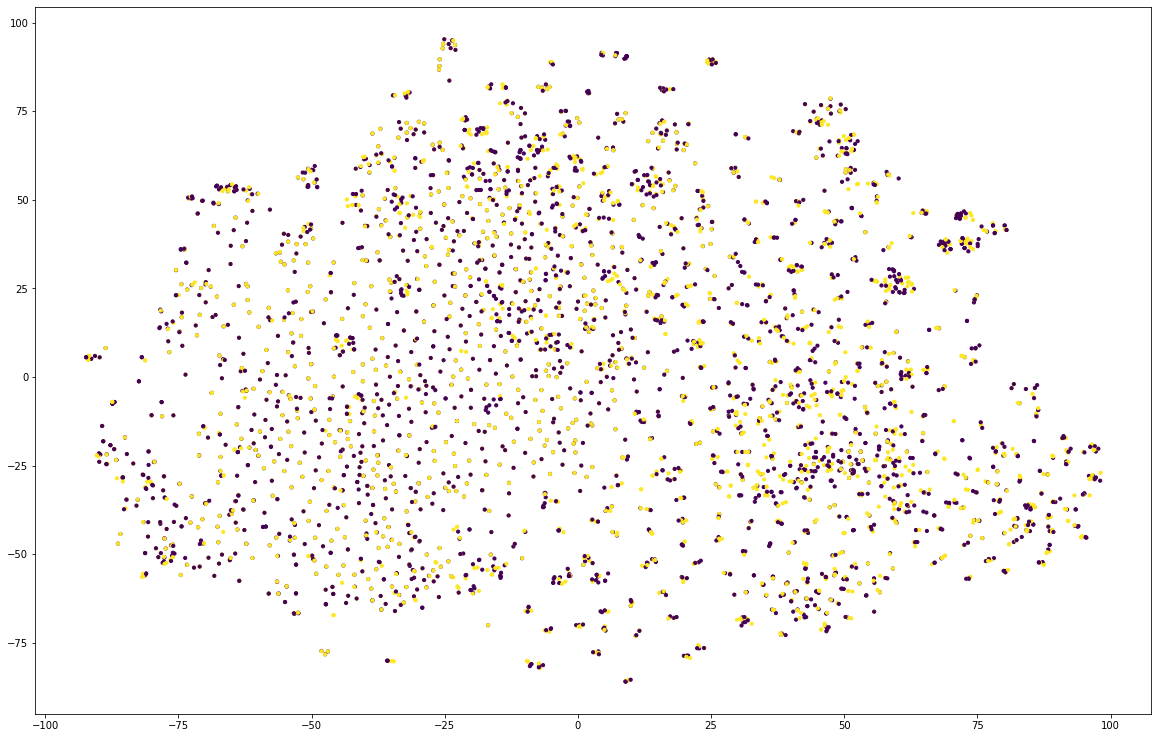

In [0]:
visualize_with_tsne(tasks)

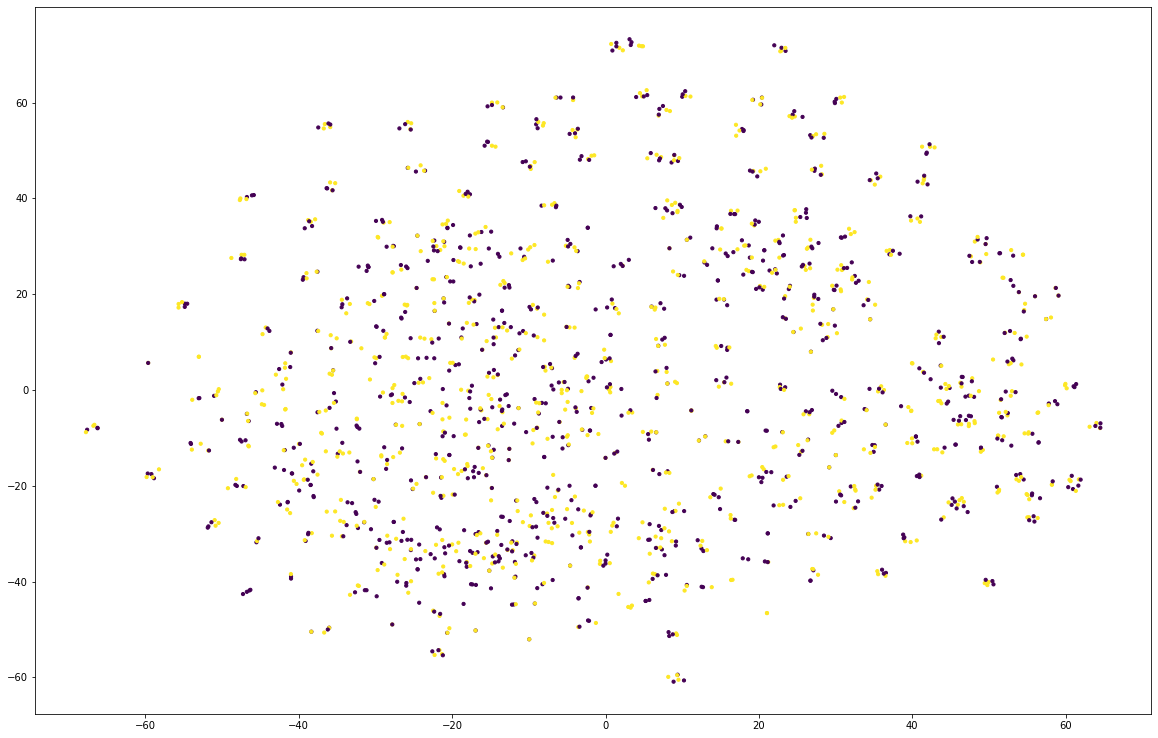

In [0]:
visualize_with_tsne(list(filter(lambda x: x['type'] == 1, tasks)))

string index out of range {'question': 'установите соответствие между функцией отдела нервной системы и отделом', 'options': {'number_options': ['соматическая нервная система', 'вегетативная нервная система'], 'letter_options': ['иннервирует скелетную мускулатуру', 'подконтрольна сознанию', 'автономна', 'центры расположены в промежуточном, продолговатом и спинном мозге', 'вне центральной нервной системы вторых узлов (ганглие', 'нет']}, 'type': 2, 'answers': ['11221']}
string index out of range {'question': 'установите соответствие между признаком, характеризующим неясыть (семейство совины', 'options': {'number_options': ['физиологический', 'экологический'], 'letter_options': ['и критерием вида признак   критерий вида', 'голос самки — раскатистая басовая трель', 'питается мышевидными грызунами', 'гнездится в смешанных лесах', 'охотится ночью', 'в кладке 2-6 белых яиц', 'птенцы насиживаются самкой 30 суток']}, 'type': 2, 'answers': ['122211']}



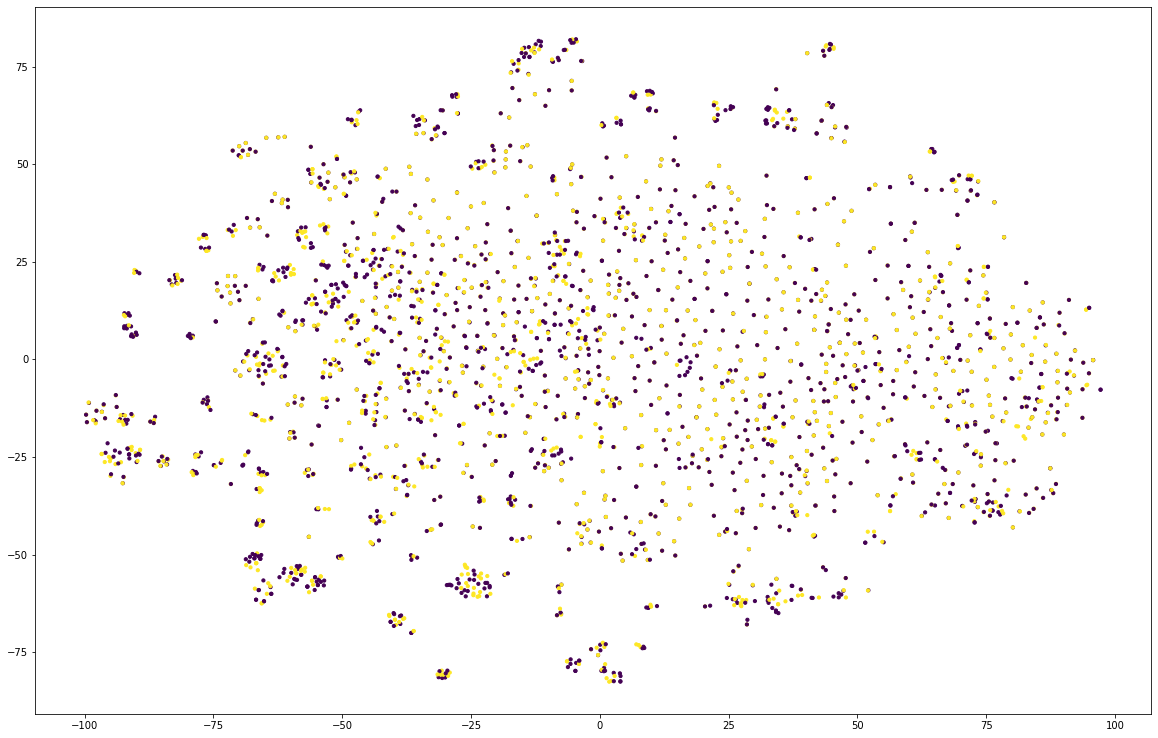

In [0]:
visualize_with_tsne(list(filter(lambda x: x['type'] == 2, tasks)))

## Квадратичная форма

In [0]:
emb = build_model(bert_config) #, download=True)

In [0]:
metrics = cross_validation(QuadraticFormSolver, [], {'embedder': emb, 'emb_dims': 768}, tasks, n_iter=3)
clear_output()
print('multiple choice:', metrics[('non_position_accuracy', 'multiple_choice')])
print('match terms:', metrics[('position_accuracy', 'match_terms')])

multiple choice: 0.4441231101008961
match terms: 0.4812013574810079


In [0]:
metrics = cross_validation(QuadraticFormWithProjectionsSolver, [], {'embedder': emb, 'emb_dims': 768, 'projection_space': 64}, tasks, n_iter=3)
clear_output()
print('multiple choice:', metrics[('non_position_accuracy', 'multiple_choice')])
print('match terms:', metrics[('position_accuracy', 'match_terms')])

multiple choice: 0.4659708951755232
match terms: 0.48034771021976963


## Bert SQuAD

In [0]:
# runtime needs to be restarted after this
! python -m deeppavlov install squad_ru_rubert
! python -m deeppavlov install ru_ranker_tfidf_wiki

In [0]:
solver = ContextBertSolver(RU_BERT_MODEL, download=True)

In [0]:
mtasks = list(filter(lambda x: x['type'] == 1, tasks))
answers = solver(mtasks) # multiple choice: 0.519774011299435

In [0]:
metrics = evaluate_model_on_different_tasks(answers, mtasks, need_print=False)
print('multiple choice:', metrics[('non_position_accuracy', 'multiple_choice')])

In [0]:
solver = OptionsContextBertSolver(RU_BERT_MODEL)

In [0]:
answers = solver(mtasks)

In [0]:
metrics = evaluate_model_on_different_tasks(answers, mtasks, need_print=False)
print('multiple choice:', metrics[('non_position_accuracy', 'multiple_choice')])